In [1]:
import matplotlib.pyplot as plt

import pandas as pd

def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.apply(lambda v: dates[v])

In [2]:
par_par   = ['PAR', 'EHD', 'WAARDE']
point_par = ['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD']
other_par = ['CPM', 'FHVEC', 'SQ', 'SP', 'TG', 'TN', 'T10NH', 'RH', 'RHX', 'GBD']

columns = ['ID'] + par_par + ['LOC', 'PLT:X', 'PLT:Y', 'DATUM', 'TIJD'] + other_par

df = pd.read_csv("../data/data_tot.csv", encoding='latin1', usecols=columns, index_col='ID', engine='c')

df.insert(0, 'DATUM:TIJD', lookup(df.DATUM + df.TIJD))
df.drop(['DATUM', 'TIJD'], axis=1, inplace=True)

/home/jasper/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
import geopandas as gpd
import pandas as pd

nld =  gpd.read_file("../doc/data/2018-Waterschappen/2018-Waterschappen.shp")

In [4]:
min(df['DATUM:TIJD'])

Timestamp('2006-01-02 06:30:00')

In [5]:
def loc_gen(df):
    for (loc,x,y),cdf in df.groupby(['LOC','PLT:X','PLT:Y']):
        yield [loc,x/100,y/100, cdf[~cdf.GBD.isna()].GBD.unique()[0], len(cdf),
               min(cdf['DATUM:TIJD']), max(cdf['DATUM:TIJD'])]
               #cdf.Ql.mean()]  # Kan niet, is LOC param.

loc_df = pd.DataFrame(list(loc_gen(df)), columns=['loc','x','y', 'gbd', 'cnt',
                                                  'fr_t','to_t'])

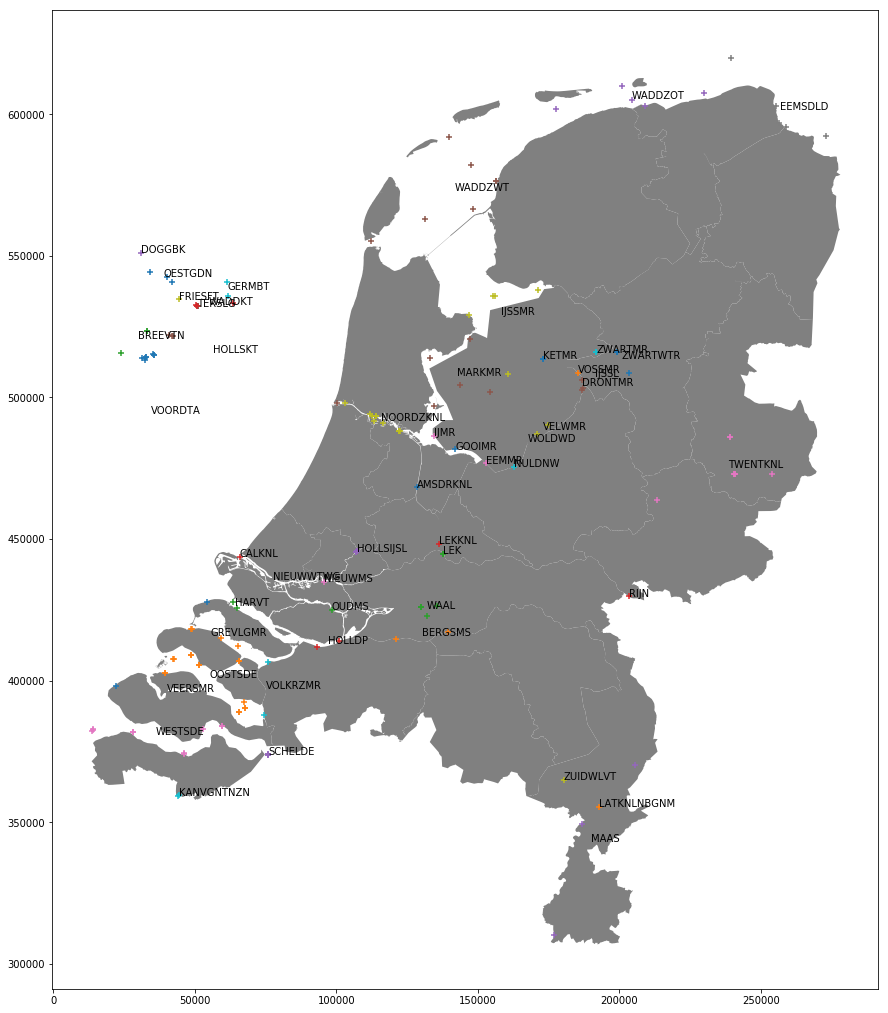

In [11]:
ax = nld.plot(color='grey', figsize=(18,18))

#loc_df[loc_df.Ql.isna()].plot.scatter('x','y', marker='+', ax=ax)

#tmp = loc_df[~loc_df.Ql.isna()]
for gbd, cdf in loc_df.groupby('gbd'):
    ax.scatter(cdf.x, cdf.y, marker='+')
    ax.text(cdf.x.mean(), cdf.y.mean(), gbd, color='black')

#for k,cdf in loc_df.groupby('loc'):`
#    ax.text(cdf.x.mean()+1000, cdf.y.mean(), k)

#oms_df[(oms_df.type=='LOCOMS') & (oms_df.n_unique > 20000)].plot.scatter(ax=ax)

In [7]:
list(loc_df[loc_df.gbd=='HARVT']['loc'].unique())

['HARVSS', 'SCHEELHK']

In [8]:
loc_df.to_csv("../data/intermediate/loc_gbd.csv")

In [9]:
import numpy as np

def extract_1_val(series):
    """Hackish way to get data."""
    return next(iter(series)) if len(series)>0 else np.nan

def combine_interests(df, interests, cols=[],
                      val='WAARDE', moment=['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD'], de_unit=True):
    # Groupby location&time, put together the `PAR` interests at that location&time.
    gen = ([l,
            [cdf[(cdf.PAR==par) & (cdf.EHD==ehd)][val] for par,ehd in interests],
            [cdf[~cdf[col].isna()][col] for col in cols]
           ]
           for l,cdf in df.groupby(moment))

    # Shape it into a dataframe.
    data = [[*list(l), *[extract_1_val(v) for v in vs], *[extract_1_val(v) for v in cv]]
            for l,vs,cv in gen]
    return pd.DataFrame(data,
                        columns = moment + (interests if not de_unit else 
                                            [n for n,u in interests] + cols))

paru =  [('ZS', 'mg/l'), ('GR','mg/l'), ('POC','mg/l'), ('DOC','mg/l'),
         ('WINDSHD', 'm/s'), ('WINDRTG', 'graad'), ('SALNTT','DIMSLS'),
         ('NO2', 'mg/l'), ('NO3', 'mg/l'), ('NH4', 'mg/l'),
         ('O2', 'mg/l'), ('P', 'mg/l'),
         ('Ql', 'l'),
        ]
#pdf3 = combine_interests(df, paru, cols=other_par)

KeyboardInterrupt: 

In [ ]:
#pd.DataFrame([(gbd, len(cdf.LOC.unique()), len(cdf)) for gbd,cdf in pdf3.groupby('GBD')],
#            columns=['gbd', 'loc_cnt', 'cnt']).sort_values('loc_cnt', ascending=False) \
#    .head(10).transpose()